# Libraries

In [1]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random

seed = 5

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
def initialize_network_params(layer_sizes, scale=1e-2, seed=0):
    """ Build a list of (weights, biases) tuples,
        one for each layer in the network. """
    rng = jax.random.PRNGKey(seed)
    keys = jax.random.split(rng, len(layer_sizes))
    return [(scale * jax.random.normal(key, (m, n)),   # weights
             scale * jax.random.normal(key, (n,)))    # biases
            for key, (m, n) in zip(keys, zip(layer_sizes[:-1], layer_sizes[1:]))]


def ReLU(x):
    """ Rectified linear unit. """
    return jnp.maximum(0, x)


def predict_item(params, inputs):
    """ Predict a single image using the trained weights. """
    activations = inputs
    for W, b in params[:-1]:
        outputs = jnp.dot(activations, W) + b
        activations = ReLU(outputs)
    final_W, final_b = params[-1]
    logits = jnp.dot(activations, final_W) + final_b
    return logits - logsumexp(logits)


def predict_batch(params, inputs):
    """ Predict a batch of images using the trained weights. """
    return vmap(predict_item, in_axes=(None, 0))(params, inputs)


def loss_fn(params, batch):
    """ Cross entropy loss for a batch of inputs/outputs. """
    inputs, targets = batch
    preds = predict_batch(params, inputs)
    return -jnp.mean(preds[jnp.arange(targets.shape[0]), targets])


def accuracy(params, batch):
    """ Accuracy for a batch of inputs/outputs. """
    inputs, targets = batch
    target_class = jnp.argmax(predict_batch(params, inputs), axis=1)
    return jnp.mean(target_class == targets)


def transform(x):
    """ Used to transform a PIL.Image to a jax.numpy.ndarray. """
    return jnp.array(x).reshape(-1, 28*28)


def custome_collate(batch):
    """ Collate function to convert a list of tuples to a tuple of lists. """
    return jnp.array([x[0] for x in batch]), np.array([x[1] for x in batch])


def convert_label(label):
    """ Convert the labels from 0-9 to the actual label names. """
    if label == 0:
        return "T-shirt/top"
    elif label == 1:
        return "Trouser"
    elif label == 2:
        return "Pullover"
    elif label == 3:
        return "Dress"
    elif label == 4:
        return "Coat"
    elif label == 5:
        return "Sandal"
    elif label == 6:
        return "Shirt"
    elif label == 7:
        return "Sneaker"
    elif label == 8:
        return "Bag"
    elif label == 9:
        return "Ankle boot"

# Data & config

In [3]:
layer_sizes = [784, 1024, 1024, 10]
num_epochs = 10
learning_rate = 0.001
batch_size = 128

# load fashion mnist dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custome_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custome_collate)

# Initialize and train

In [4]:
params = initialize_network_params(layer_sizes, seed=seed)


@jit
def train_step(params, batch):
    loss, grads = value_and_grad(loss_fn)(params, batch)
    return loss, [(w - learning_rate * dw, b - learning_rate * db)
                  for (w, b), (dw, db) in zip(params, grads)]

for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.reshape(-1, 28*28)
        loss, params = train_step(params, (data, target))
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} | Batch: {batch_idx} | Loss: {loss}')

Epoch: 0 | Batch: 0 | Loss: 2.792550563812256
Epoch: 0 | Batch: 100 | Loss: 0.5713967084884644
Epoch: 0 | Batch: 200 | Loss: 0.48755449056625366
Epoch: 0 | Batch: 300 | Loss: 0.5775946378707886
Epoch: 0 | Batch: 400 | Loss: 0.4662013649940491
Epoch: 1 | Batch: 0 | Loss: 0.4949067234992981
Epoch: 1 | Batch: 100 | Loss: 0.4568464159965515
Epoch: 1 | Batch: 200 | Loss: 0.3180035352706909
Epoch: 1 | Batch: 300 | Loss: 0.4556054472923279
Epoch: 1 | Batch: 400 | Loss: 0.4144655168056488
Epoch: 2 | Batch: 0 | Loss: 0.3811339735984802
Epoch: 2 | Batch: 100 | Loss: 0.36615607142448425
Epoch: 2 | Batch: 200 | Loss: 0.33314064145088196
Epoch: 2 | Batch: 300 | Loss: 0.5019170045852661
Epoch: 2 | Batch: 400 | Loss: 0.3307340145111084
Epoch: 3 | Batch: 0 | Loss: 0.32832223176956177
Epoch: 3 | Batch: 100 | Loss: 0.38729554414749146
Epoch: 3 | Batch: 200 | Loss: 0.34894102811813354
Epoch: 3 | Batch: 300 | Loss: 0.43623703718185425
Epoch: 3 | Batch: 400 | Loss: 0.32839253544807434
Epoch: 4 | Batch: 0 |

# Test & visualize

In [7]:
total_correct = 0
total = 0
for batch_idx, (data, target) in enumerate(test_loader):
    data = data.reshape(-1, 28*28)
    total_correct += accuracy(params, (data, target)) * data.shape[0]
    total += data.shape[0]
print(f'Total Test Accuracy: {total_correct / total}')

Total Test Accuracy: 0.8707000017166138


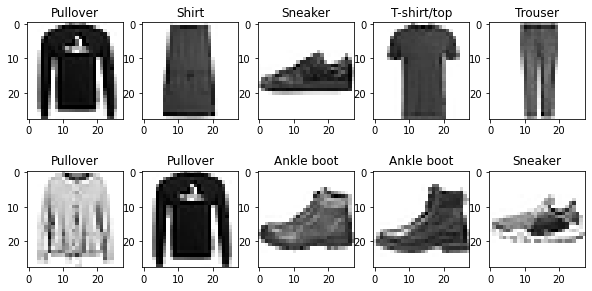

In [6]:
images, labels = next(iter(test_loader))
images = images.reshape(-1, 28*28)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    idx = random.randint(0, len(images)-1)
    ax.imshow(images[idx].reshape(28, 28), cmap="binary")
    ax.set(title = "{}".format(convert_label(np.argmax(predict_batch(params, images[idx:idx+1])))))

plt.show()